In [1]:
%%capture cap
!pip install ipywidgets
!pip install autogluon scikit-learn==1.5.2 
!apt-get install -y graphviz graphviz-dev && pip install pydot
!pip install pygraphviz

In [2]:
import torch
import os
import pydot

import numpy as np
import pandas as pd
from time import time
from tqdm.auto import tqdm
from itertools import combinations

from IPython.display import display, Image
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
# pd.options.mode.copy_on_write = True
# plt.style.use("ggplot")
# sns.set_style("whitegrid")

## -- Ansi color codes --
COLOR = '\033[32m'
RESET = '\033[0m'

In [3]:
### Load Data ###
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
                  ignore_index=True)

# X_test = pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(include='object').columns.tolist()
BOOL = test.select_dtypes(include='bool').columns.tolist()
FEATURES = NUMS + CATS + BOOL

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} has shape: {df.shape}")

print(f"\nTotal Numerical   : {len(NUMS)}")
print(f"Total Categorical : {len(CATS)}")
print(f"Total Boolean     : {len(BOOL)}")

Train has shape: (517754, 13)
Test has shape: (172585, 12)
Original has shape: (112000, 13)

Total Numerical   : 4
Total Categorical : 4
Total Boolean     : 4


In [4]:
## -- meta feature --
# BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
for df in [train, test, orig]:
    base_risk = (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
            )
    df['meta'] = base_risk

    # df['BINARY'] = 0
    # for i in range(len(BINARY_COLS)):
    #     df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)
FEATURES.append('meta')
print(f"✅ 'meta' feature created!")
# print(f"✅ 'BINARY' feature created!")

✅ 'meta' feature created!


In [5]:
display(train[TARGET].mean(), train[TARGET].max(), train[TARGET].min())
display(train.meta.mean(), train.meta.max(), train.meta.min())
np.corrcoef(train.meta.values, train[TARGET].values)[1, 0]

0.3523774031683

1.0

0.0

0.352316535789004

0.9

0.0

0.9366316125061894

In [6]:
display(train.head())
train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta
id,,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,0.118
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,0.297
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,0.389
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,0.121
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,0.474


<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517754 non-null  object 
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   lighting                517754 non-null  object 
 5   weather                 517754 non-null  object 
 6   road_signs_present      517754 non-null  bool   
 7   public_road             517754 non-null  bool   
 8   time_of_day             517754 non-null  object 
 9   holiday                 517754 non-null  bool   
 10  school_season           517754 non-null  bool   
 11  num_reported_accidents  517754 non-null  int64  
 12  accident_risk           517754 non-null  float64
 13  meta                    517754 non-null  float64
dtypes: bool(4), float64(3), i

In [7]:
def plot_heatmap(data, cat_features: list, title: str):
    df = data.copy()
    for c in cat_features:
        df[c], _ = pd.factorize(df[c])
    plt.figure(figsize=(18, 7))
    sns.heatmap(df.corr('spearman'), mask=np.triu(df.corr('spearman')), annot=True)
    plt.title(title, size=15, fontweight='semibold')
    plt.tight_layout()
    plt.show()

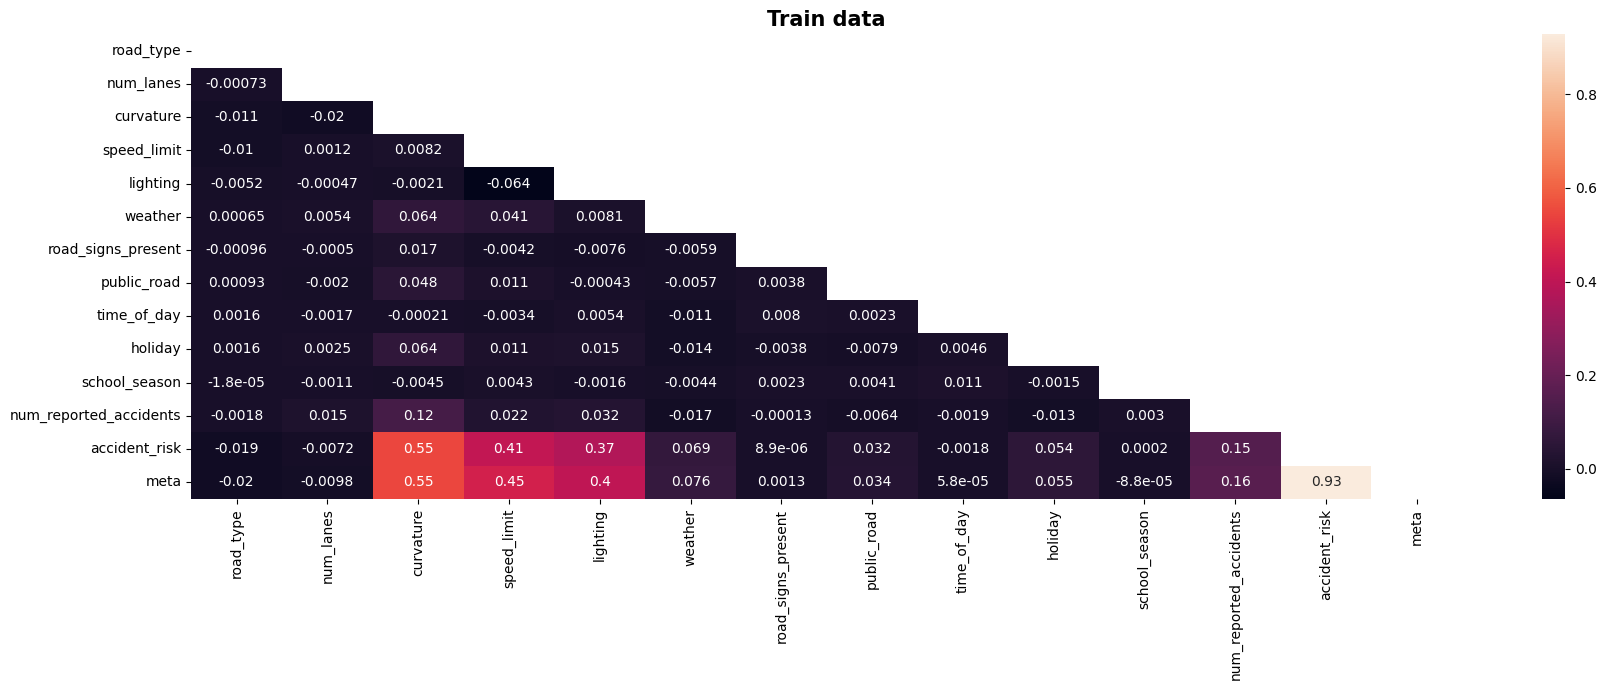

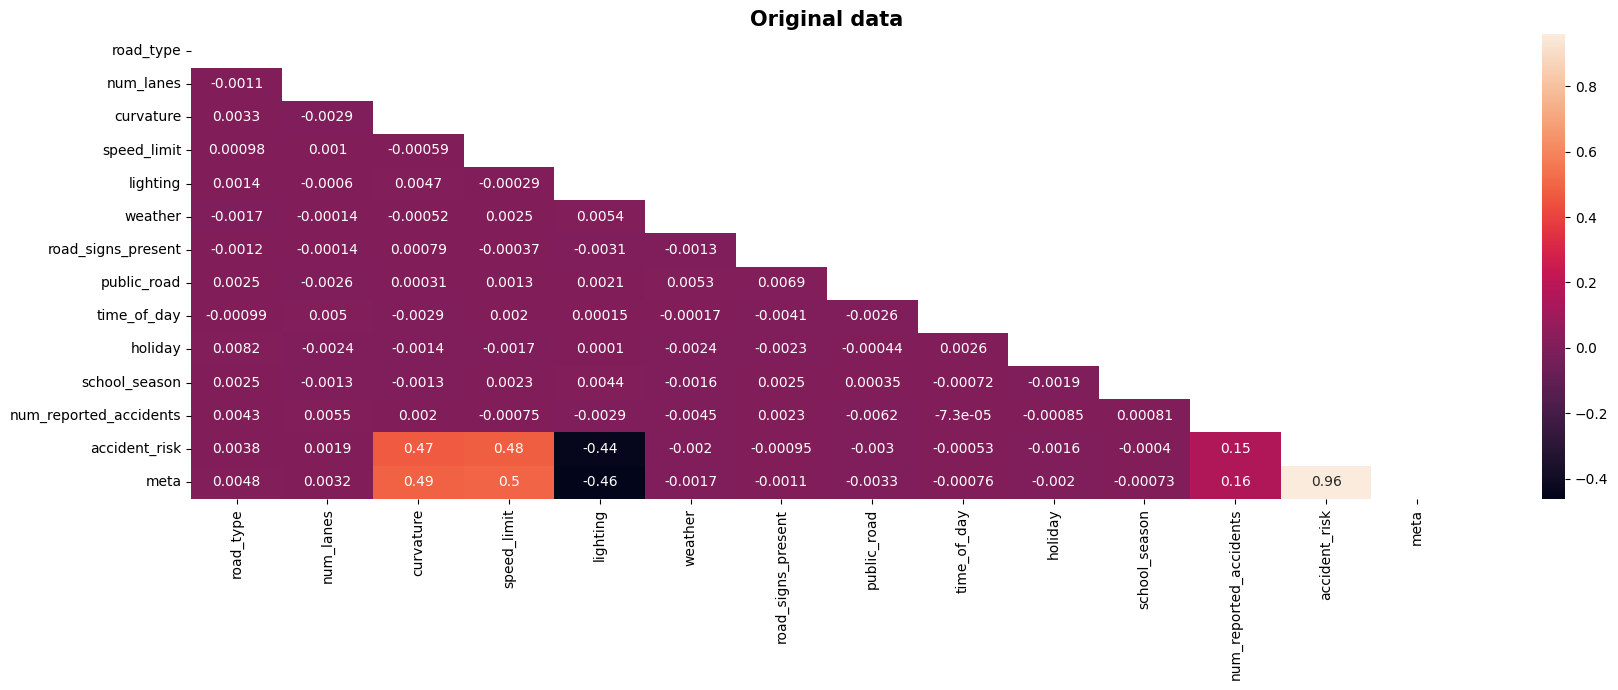

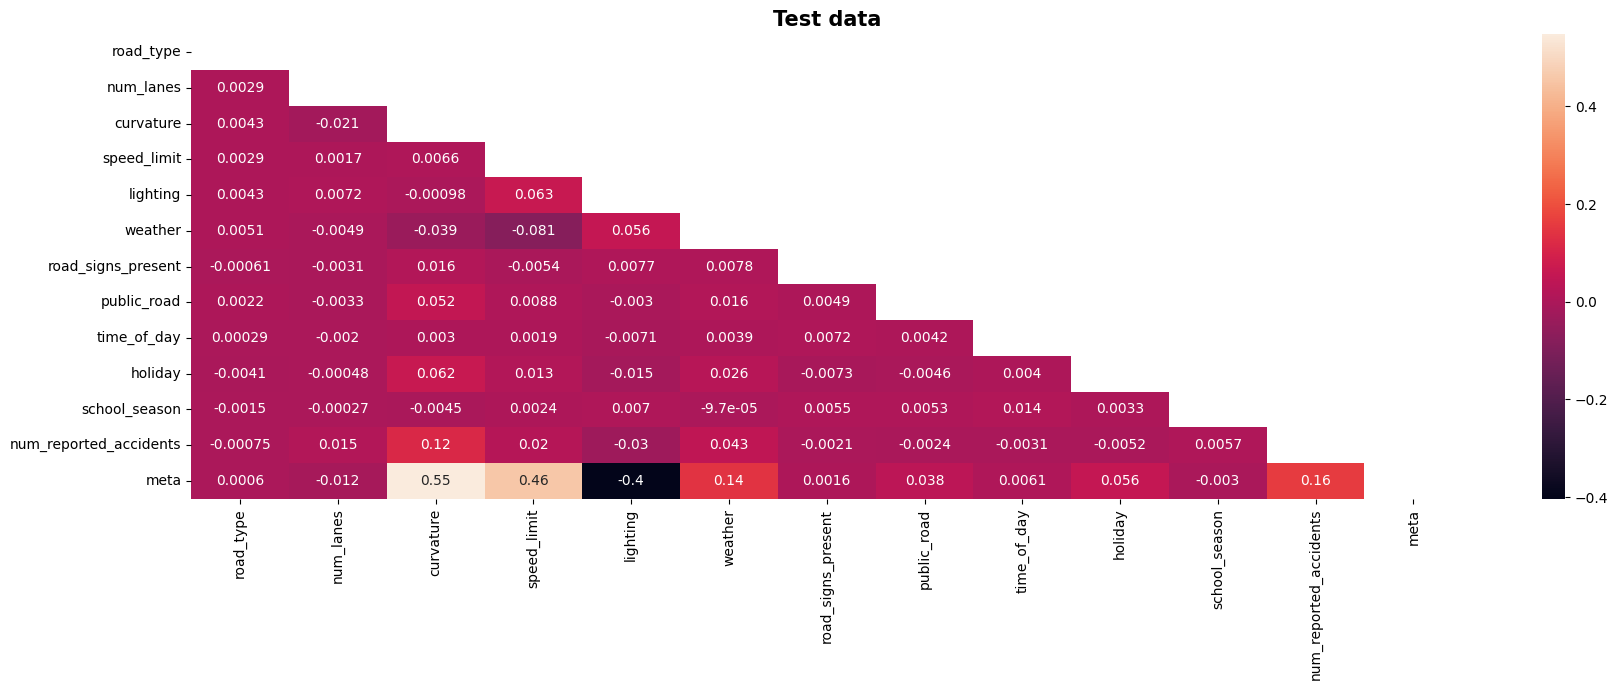

In [8]:
plot_heatmap(train, CATS, "Train data")
plot_heatmap(orig, CATS, "Original data")
plot_heatmap(test, CATS, "Test data")

In [9]:
CATS2 = []
print(f"Categorization... ", end="")
for c in FEATURES:
    print(f"{c}, ", end="")
    n = f"cat_{c}"
    train[n] = train[c].astype('category')
    cat = train[n].cat
    test[n] = pd.Categorical(test[c], categories=cat.categories)
    CATS2.append(n)

print()
display(train.head())
train.info()

Categorization... num_lanes, curvature, speed_limit, num_reported_accidents, road_type, lighting, weather, time_of_day, road_signs_present, public_road, holiday, school_season, meta, 


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,cat_num_lanes,cat_curvature,cat_speed_limit,cat_num_reported_accidents,cat_road_type,cat_lighting,cat_weather,cat_time_of_day,cat_road_signs_present,cat_public_road,cat_holiday,cat_school_season,cat_meta
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13,0.118,2,0.06,35,1,urban,daylight,rainy,afternoon,False,True,False,True,0.118
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35,0.297,4,0.99,35,0,urban,daylight,clear,evening,True,False,True,True,0.297
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30,0.389,4,0.63,70,2,rural,dim,clear,morning,False,True,True,False,0.389
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21,0.121,4,0.07,35,1,highway,dim,rainy,morning,True,True,False,False,0.121
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56,0.474,1,0.58,60,1,rural,daylight,foggy,evening,False,False,True,False,0.474


<class 'pandas.core.frame.DataFrame'>
Index: 517754 entries, 0 to 517753
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   road_type                   517754 non-null  object  
 1   num_lanes                   517754 non-null  int64   
 2   curvature                   517754 non-null  float64 
 3   speed_limit                 517754 non-null  int64   
 4   lighting                    517754 non-null  object  
 5   weather                     517754 non-null  object  
 6   road_signs_present          517754 non-null  bool    
 7   public_road                 517754 non-null  bool    
 8   time_of_day                 517754 non-null  object  
 9   holiday                     517754 non-null  bool    
 10  school_season               517754 non-null  bool    
 11  num_reported_accidents      517754 non-null  int64   
 12  accident_risk               517754 non-null  float64 
 13  meta

In [10]:
## -- Factorize using combined data --
print(f"Label encoding... ", end="")
for c in CATS:
    if c not in BOOL:
        print(f"{c}, ", end="")
        combined = pd.concat([train[c], test[c], orig[c]], axis=0)
        combined = combined.factorize()[0]
        train[c] = combined[:len(train)].astype("int8")
        test[c]  = combined[len(train):len(train)+len(test)].astype("int8")
        orig[c]  = combined[-len(orig):].astype("int8")

Label encoding... road_type, lighting, weather, time_of_day, 

In [11]:
## -- CREATE FEATURES -- ##
def create_features(train_df, test_df, orig_df):
    train = train_df.copy()
    test  = test_df.copy()
    orig  = orig_df.copy()

    DIGITS = []
    for c in ['curvature', 'speed_limit']: # only features with > 1 digits
        for i in range(-3, 3):
            n = f"{c}_{i}"
            train[n] = ((train[c] * 10**i) % 10).astype("int8")
            test[n]  = ((test[c]  * 10**i) % 10).astype("int8")
            orig[n]  = ((orig[c]  * 10**i) % 10).astype("int8")
            if train[n].nunique()==1:
                train = train.drop([n], axis=1)
                test  = test.drop([n],  axis=1)
                orig  = orig.drop([n],  axis=1)
            else:
                DIGITS.append(n)
    print(f"✅  Digits extract features: {len(DIGITS)}")
    for col in DIGITS:
        print(f"{col}: {train[col].nunique()} unique values")

    ## -- FEATURE 1: Use original as features
    # BINARY_COLS.remove('holiday')
    # FEAT = [c for c in test.columns if c not in BINARY_COLS] # Exclude binned features
    print(f"Merging {len(FEATURES)} features: ", end="")
    STATS = ['mean','count','std','max','min'] # 
    for c in FEATURES:
        print(f"{c}, ", end="")
        tmp = orig.groupby(c)[TARGET].agg(STATS)
        tmp.columns = [f"OTE_{c}_{s.upper()}" for s in STATS]
        train = train.merge(tmp, on=c, how='left')
        test  = test.merge(tmp,  on=c, how='left')
    print()

    BINS = []
    print(f"\nCreating bins... ", end="")
    for c in ['curvature', 'meta']: # <- add feature 1 after the other
        for b in [4, 10]:
            print(f"{c}_{b}, ", end="")
            b_n = f'{c}_bin_{b}'
            # Fit on train data and transform both train and test
            bins = np.linspace(train[c].min(), train[c].max(), b+1)
            train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
            test[b_n]  = pd.cut(test[c],  include_lowest=True, labels=False, bins=bins)
            BINS.append(b_n)
    print()
    print(f"✅ {len(BINS)} binned features created!")

    ## -- Polynomials --
    for df in [train, test]:
        df['curvature_sqrt'] = np.sqrt(df['curvature']) # Square-root
        df['curvature_squared'] = df['curvature'] ** 2 # Squared
        df['curvature_cubed'] = df['curvature'] ** 3 # Cubed
        df['curve-+-speed-+-light'] = df[['curvature', 'speed_limit', 'lighting']].sum(axis=1)
    print(f"✅ Polynomial features created!")

    ## -- Pairwise combinations --
    TE = []
    for n in [2]:
        for cols in tqdm(list(combinations(CATS2, n)), desc="Creating Pairwise"):
            n = '-|-'.join(sorted(cols))
            train[n] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
            test[n] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)
            train[n] = train[n].astype('category')
            
            cat = train[n].cat
            train[n] = train[n].cat.codes
            
            test[n] = pd.Categorical(test[n], categories=cat.categories).codes
            TE.append(n)

    ## -- Triplewise combinations --
    # TOP_PREDICTORS = ['curvature','lighting','speed_limit','weather','num_reported_accidents']
    for n in [3]:
        for cols in tqdm(list(combinations(CATS2, n)), desc="Creating Triplewise"):
            nm = '-|-'.join(sorted(cols))
            train[nm] = train[cols[0]].astype(str) + '_' + \
                        train[cols[1]].astype(str) + '_' + \
                        train[cols[2]].astype(str)
            test[nm]  = test[cols[0]].astype(str) + '_' + \
                        test[cols[1]].astype(str) + '_' + \
                        test[cols[2]].astype(str)
            
            train[nm] = train[nm].astype('category')
            cat = train[nm].cat
            train[nm] = train[nm].cat.codes
            test[nm] = pd.Categorical(test[nm], categories=cat.categories).codes
            TE.append(nm)

    print(f"✅ Interations (TE) created: {len(TE)}")
    print(f"✅ Binned features (BINS): {len(BINS)}")
    print(f"{COLOR}{'='*50}")
    print(f"ℹ️ Feature Engineering Complete!")
    print(f"ℹ️ Total features: {len(test.columns)}")
    print(f"{'='*50}")

    return train, test#, valid

In [12]:
train, test = create_features(train, test, orig)

✅  Digits extract features: 5
curvature_0: 2 unique values
curvature_1: 10 unique values
curvature_2: 10 unique values
speed_limit_-1: 5 unique values
speed_limit_0: 2 unique values
Merging 13 features: num_lanes, curvature, speed_limit, num_reported_accidents, road_type, lighting, weather, time_of_day, road_signs_present, public_road, holiday, school_season, meta, 

Creating bins... curvature_4, curvature_10, meta_4, meta_10, 
✅ 4 binned features created!
✅ Polynomial features created!


Creating Pairwise:   0%|          | 0/78 [00:00<?, ?it/s]

Creating Triplewise:   0%|          | 0/286 [00:00<?, ?it/s]

✅ Interations (TE) created: 364
✅ Binned features (BINS): 4
ℹ️ Feature Engineering Complete!
ℹ️ Total features: 468


In [13]:
train.shape, test.shape

((517754, 469), (172585, 468))

In [14]:
display(train.head())
# train.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,cat_num_lanes,cat_curvature,cat_speed_limit,cat_num_reported_accidents,cat_road_type,cat_lighting,cat_weather,cat_time_of_day,cat_road_signs_present,cat_public_road,cat_holiday,cat_school_season,cat_meta,curvature_0,curvature_1,curvature_2,speed_limit_-1,speed_limit_0,OTE_num_lanes_MEAN,OTE_num_lanes_COUNT,OTE_num_lanes_STD,OTE_num_lanes_MAX,OTE_num_lanes_MIN,OTE_curvature_MEAN,OTE_curvature_COUNT,OTE_curvature_STD,OTE_curvature_MAX,OTE_curvature_MIN,OTE_speed_limit_MEAN,OTE_speed_limit_COUNT,OTE_speed_limit_STD,OTE_speed_limit_MAX,OTE_speed_limit_MIN,OTE_num_reported_accidents_MEAN,OTE_num_reported_accidents_COUNT,OTE_num_reported_accidents_STD,OTE_num_reported_accidents_MAX,OTE_num_reported_accidents_MIN,OTE_road_type_MEAN,OTE_road_type_COUNT,OTE_road_type_STD,OTE_road_type_MAX,OTE_road_type_MIN,OTE_lighting_MEAN,OTE_lighting_COUNT,OTE_lighting_STD,OTE_lighting_MAX,OTE_lighting_MIN,OTE_weather_MEAN,OTE_weather_COUNT,OTE_weather_STD,OTE_weather_MAX,OTE_weather_MIN,OTE_time_of_day_MEAN,OTE_time_of_day_COUNT,OTE_time_of_day_STD,OTE_time_of_day_MAX,OTE_time_of_day_MIN,OTE_road_signs_present_MEAN,OTE_road_signs_present_COUNT,OTE_road_signs_present_STD,OTE_road_signs_present_MAX,OTE_road_signs_present_MIN,OTE_public_road_MEAN,OTE_public_road_COUNT,OTE_public_road_STD,OTE_public_road_MAX,OTE_public_road_MIN,OTE_holiday_MEAN,OTE_holiday_COUNT,OTE_holiday_STD,OTE_holiday_MAX,OTE_holiday_MIN,OTE_school_season_MEAN,OTE_school_season_COUNT,OTE_school_season_STD,OTE_school_season_MAX,OTE_school_season_MIN,OTE_meta_MEAN,OTE_meta_COUNT,OTE_meta_STD,OTE_meta_MAX,OTE_meta_MIN,curvature_bin_4,curvature_bin_10,meta_bin_4,meta_bin_10,curvature_sqrt,curvature_squared,curvature_cubed,curve-+-speed-+-light,cat_curvature-|-cat_num_lanes,cat_num_lanes-|-cat_speed_limit,cat_num_lanes-|-cat_num_reported_accidents,cat_num_lanes-|-cat_road_type,cat_lighting-|-cat_num_lanes,cat_num_lanes-|-cat_weather,cat_num_lanes-|-cat_time_of_day,cat_num_lanes-|-cat_road_signs_present,cat_num_lanes-|-cat_public_road,cat_holiday-|-cat_num_lanes,cat_num_lanes-|-cat_school_season,cat_meta-|-cat_num_lanes,cat_curvature-|-cat_speed_limit,cat_curvature-|-cat_num_reported_accidents,cat_curvature-|-cat_road_type,cat_curvature-|-cat_lighting,cat_curvature-|-cat_weather,cat_curvature-|-cat_time_of_day,cat_curvature-|-cat_road_signs_present,cat_curvature-|-cat_public_road,cat_curvature-|-cat_holiday,cat_curvature-|-cat_school_season,cat_curvature-|-cat_meta,cat_num_reported_accidents-|-cat_speed_limit,cat_road_type-|-cat_speed_limit,cat_lighting-|-cat_speed_limit,cat_speed_limit-|-cat_weather,cat_speed_limit-|-cat_time_of_day,cat_road_signs_present-|-cat_speed_limit,cat_public_road-|-cat_speed_limit,cat_holiday-|-cat_speed_limit,cat_school_season-|-cat_speed_limit,cat_meta-|-cat_speed_limit,cat_num_reported_accidents-|-cat_road_type,cat_lighting-|-cat_num_reported_accidents,cat_num_reported_accidents-|-cat_weather,cat_num_reported_accidents-|-cat_time_of_day,cat_num_reported_accidents-|-cat_road_signs_present,cat_num_reported_accidents-|-cat_public_road,cat_holiday-|-cat_num_reported_accidents,cat_num_reported_accidents-|-cat_school_season,cat_meta-|-cat_num_reported_accidents,cat_lighting-|-cat_road_type,cat_road_type-|-cat_weather,cat_road_type-|-cat_time_of_day,cat_road_signs_present-|-cat_road_type,cat_public_road-|-cat_road_type,cat_holiday-|-cat_road_type,cat_road_type-|-cat_school_season,cat_meta-|-cat_road_type,cat_lighting-|-cat_weather,cat_lighting-|-cat_time_of_day,cat_lighting-|-cat_road_signs_present,cat_lighting-|-cat_public_road,cat_holiday-|-cat_lighting,cat_lighting-|-cat_school_season,cat_lighting-|-cat_meta,cat_time_of_day-|-cat_weather,cat_road_signs_present-|-cat_weather,cat_public_road-|-cat_weather,cat_holiday-|-cat_weather,cat_school_season-|-cat_weather,cat_meta-|-cat_weather,cat_road_signs

In [15]:
display(test.head())
# test.info()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,meta,cat_num_lanes,cat_curvature,cat_speed_limit,cat_num_reported_accidents,cat_road_type,cat_lighting,cat_weather,cat_time_of_day,cat_road_signs_present,cat_public_road,cat_holiday,cat_school_season,cat_meta,curvature_0,curvature_1,curvature_2,speed_limit_-1,speed_limit_0,OTE_num_lanes_MEAN,OTE_num_lanes_COUNT,OTE_num_lanes_STD,OTE_num_lanes_MAX,OTE_num_lanes_MIN,OTE_curvature_MEAN,OTE_curvature_COUNT,OTE_curvature_STD,OTE_curvature_MAX,OTE_curvature_MIN,OTE_speed_limit_MEAN,OTE_speed_limit_COUNT,OTE_speed_limit_STD,OTE_speed_limit_MAX,OTE_speed_limit_MIN,OTE_num_reported_accidents_MEAN,OTE_num_reported_accidents_COUNT,OTE_num_reported_accidents_STD,OTE_num_reported_accidents_MAX,OTE_num_reported_accidents_MIN,OTE_road_type_MEAN,OTE_road_type_COUNT,OTE_road_type_STD,OTE_road_type_MAX,OTE_road_type_MIN,OTE_lighting_MEAN,OTE_lighting_COUNT,OTE_lighting_STD,OTE_lighting_MAX,OTE_lighting_MIN,OTE_weather_MEAN,OTE_weather_COUNT,OTE_weather_STD,OTE_weather_MAX,OTE_weather_MIN,OTE_time_of_day_MEAN,OTE_time_of_day_COUNT,OTE_time_of_day_STD,OTE_time_of_day_MAX,OTE_time_of_day_MIN,OTE_road_signs_present_MEAN,OTE_road_signs_present_COUNT,OTE_road_signs_present_STD,OTE_road_signs_present_MAX,OTE_road_signs_present_MIN,OTE_public_road_MEAN,OTE_public_road_COUNT,OTE_public_road_STD,OTE_public_road_MAX,OTE_public_road_MIN,OTE_holiday_MEAN,OTE_holiday_COUNT,OTE_holiday_STD,OTE_holiday_MAX,OTE_holiday_MIN,OTE_school_season_MEAN,OTE_school_season_COUNT,OTE_school_season_STD,OTE_school_season_MAX,OTE_school_season_MIN,OTE_meta_MEAN,OTE_meta_COUNT,OTE_meta_STD,OTE_meta_MAX,OTE_meta_MIN,curvature_bin_4,curvature_bin_10,meta_bin_4,meta_bin_10,curvature_sqrt,curvature_squared,curvature_cubed,curve-+-speed-+-light,cat_curvature-|-cat_num_lanes,cat_num_lanes-|-cat_speed_limit,cat_num_lanes-|-cat_num_reported_accidents,cat_num_lanes-|-cat_road_type,cat_lighting-|-cat_num_lanes,cat_num_lanes-|-cat_weather,cat_num_lanes-|-cat_time_of_day,cat_num_lanes-|-cat_road_signs_present,cat_num_lanes-|-cat_public_road,cat_holiday-|-cat_num_lanes,cat_num_lanes-|-cat_school_season,cat_meta-|-cat_num_lanes,cat_curvature-|-cat_speed_limit,cat_curvature-|-cat_num_reported_accidents,cat_curvature-|-cat_road_type,cat_curvature-|-cat_lighting,cat_curvature-|-cat_weather,cat_curvature-|-cat_time_of_day,cat_curvature-|-cat_road_signs_present,cat_curvature-|-cat_public_road,cat_curvature-|-cat_holiday,cat_curvature-|-cat_school_season,cat_curvature-|-cat_meta,cat_num_reported_accidents-|-cat_speed_limit,cat_road_type-|-cat_speed_limit,cat_lighting-|-cat_speed_limit,cat_speed_limit-|-cat_weather,cat_speed_limit-|-cat_time_of_day,cat_road_signs_present-|-cat_speed_limit,cat_public_road-|-cat_speed_limit,cat_holiday-|-cat_speed_limit,cat_school_season-|-cat_speed_limit,cat_meta-|-cat_speed_limit,cat_num_reported_accidents-|-cat_road_type,cat_lighting-|-cat_num_reported_accidents,cat_num_reported_accidents-|-cat_weather,cat_num_reported_accidents-|-cat_time_of_day,cat_num_reported_accidents-|-cat_road_signs_present,cat_num_reported_accidents-|-cat_public_road,cat_holiday-|-cat_num_reported_accidents,cat_num_reported_accidents-|-cat_school_season,cat_meta-|-cat_num_reported_accidents,cat_lighting-|-cat_road_type,cat_road_type-|-cat_weather,cat_road_type-|-cat_time_of_day,cat_road_signs_present-|-cat_road_type,cat_public_road-|-cat_road_type,cat_holiday-|-cat_road_type,cat_road_type-|-cat_school_season,cat_meta-|-cat_road_type,cat_lighting-|-cat_weather,cat_lighting-|-cat_time_of_day,cat_lighting-|-cat_road_signs_present,cat_lighting-|-cat_public_road,cat_holiday-|-cat_lighting,cat_lighting-|-cat_school_season,cat_lighting-|-cat_meta,cat_time_of_day-|-cat_weather,cat_road_signs_present-|-cat_weather,cat_public_road-|-cat_weather,cat_holiday-|-cat_weather,cat_school_season-|-cat_weather,cat_meta-|-cat_weather,cat_road_signs_present-|-cat

In [16]:
# !rm -r /kaggle/working/AG_accident_models

In [17]:
from autogluon.tabular import TabularPredictor

## -- RUN 1: Use train data -- 
predictor = TabularPredictor(
                label = TARGET,
         problem_type = "regression",
          eval_metric = "rmse",
                 path = "./AG_accident_models",
).fit(
                   train_data = train,
                      presets = 'best',
                num_bag_folds = 8,
             dynamic_stacking = False,
                   # auto_stack = False,
             num_stack_levels = 1,
                 # num_bag_sets = 2,
                   time_limit = 3600*11,
        # [ 'XGB', 'GBM', 'CAT', 'RF', 'XT', 'FASTAI', 'NN_TORCH']
         # included_model_types = ['RF', 'XT', 'FASTAI'],
                     # num_gpus = torch.cuda.device_count(),
                  # ag_args_fit = {'num_cpus': os.cpu_count() - 1},
) 

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Nov 10 10:07:59 UTC 2024
CPU Count:          4
Memory Avail:       29.06 GB / 31.35 GB (92.7%)
Disk Space Avail:   19.50 GB / 19.52 GB (99.9%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 39600s
AutoGluon will save models to "/kaggle/working/AG_accident_models"
Train Data Rows:    517754
Train Data Columns: 468
Label Column:       accident_risk
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                 

In [18]:
## -- Get Summary --
print(f"-> Total models : {len(predictor.model_names())}")
print(f"-> Best model   : {predictor.model_best}") 

## -- Observe RUN 1 RESULTS --
leaderboard = predictor.leaderboard(silent=True)
leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral")

-> Total models : 10
-> Best model   : WeightedEnsemble_L3


,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.055848,root_mean_squared_error,313.088532,38625.531569,0.009802,0.677633,3,True,10
1,WeightedEnsemble_L2,-0.055977,root_mean_squared_error,211.789344,25132.674482,0.009863,0.500338,2,True,6
2,LightGBM_BAG_L2,-0.056009,root_mean_squared_error,238.568410,26962.405700,8.371138,757.710348,2,True,8
3,CatBoost_BAG_L1,-0.056020,root_mean_squared_error,8.698915,5863.699376,8.698915,5863.699376,1,True,4
4,LightGBMXT_BAG_L2,-0.056046,root_mean_squared_error,243.107685,27012.768425,12.910413,808.073074,2,True,7
5,RandomForestMSE_BAG_L2,-0.056051,root_mean_squared_error,304.707592,37867.143588,74.510320,11662.448236,2,True,9
6,LightGBMXT_BAG_L1,-0.056054,root_mean_squared_error,37.814539,1435.277093,37.814539,1435.277093,1,True,1
7,LightGBM_BAG_L1,-0.056118,root_mean_squared_error,18.417791,1072.521208,18.417791,1072.521208,1,True,2
8,RandomForestMSE_BAG_L1,-0.056969,root_mean_squared_error,136.461315,16373.870785,136.461315,16373.870785,1,True,3
9,ExtraTreesMSE_BAG_L1,-0.057000,root_mean_squared_error,28.804712,1459.326890,28.804712,1459.326890,1,True,5


In [19]:
## -- RUN 2: Use original data as extra learning input --
# predictor.fit_pseudolabel(
#                 orig,
#                 use_ensemble = True,
#                 fit_ensemble = True,
#                 time_limit   = 3600*5,
#                 ag_args_fit  = {'num_cpus': os.cpu_count() - 1},
# )

In [20]:
## -- Get Summary -- 
# print(f"""
#     # {'█'*5}| Total models : {len(predictor.model_names())}
#     # {'█'*5}| Best model   : {predictor.model_best}
#         """)

# # -- Observe RUN 2 RESULTS --
# leaderboard = predictor.leaderboard(silent=True)
# display(leaderboard.style.background_gradient(subset=["score_val"], cmap="Spectral"))

In [21]:
## -- Create folder directory to save predictions --
NAME_EXT = "_FE468-CPU"
FOLDER   = "AG_accident_predictions"
!mkdir /kaggle/working/{FOLDER}{NAME_EXT}

In [22]:
## -- Make predictions from best model --
pred_df = predictor.predict(test)

## -- Make Submission --
submit = pd.read_csv(PATH+"sample_submission.csv")

SUBMIT_FILE = f'submit_AG{NAME_EXT}.csv'
submit[TARGET] = pred_df.values
submit.to_csv(SUBMIT_FILE, index=False)
print(f"---> Submission file saved as: {SUBMIT_FILE} !")
submit.head(10)

---> Submission file saved as: submit_AG_FE468-CPU.csv !


,id,accident_risk
0,517754,0.295168
1,517755,0.122926
2,517756,0.181429
3,517757,0.311465
4,517758,0.395702
5,517759,0.460055
6,517760,0.260402
7,517761,0.194578
8,517762,0.372855
9,517763,0.324716


In [23]:
## -- Generate predictions for all models --
ag_multi_test_proba = predictor.predict_multi(test)

## -- Save TEST predictions of all models --
final_test_data = {}
DESC = "Exporting TEST predictions"

for k, v in tqdm(ag_multi_test_proba.items(), desc=DESC):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_test_data[k_renamed] = v

SAVE_PRED = f"/kaggle/working/{FOLDER}{NAME_EXT}/pred_ag{NAME_EXT}.parquet"
final_test_df = pd.DataFrame(final_test_data)
final_test_df.to_parquet(SAVE_PRED, index=False)
final_test_df.head()

Exporting TEST predictions:   0%|          | 0/10 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE468-CPU,LightGBMBAGL1_FE468-CPU,RandomForestMSEBAGL1_FE468-CPU,CatBoostBAGL1_FE468-CPU,ExtraTreesMSEBAGL1_FE468-CPU,WeightedEnsembleL2_FE468-CPU,LightGBMXTBAGL2_FE468-CPU,LightGBMBAGL2_FE468-CPU,RandomForestMSEBAGL2_FE468-CPU,WeightedEnsembleL3_FE468-CPU
0,0.291007,0.292028,0.310842,0.294705,0.305391,0.294585,0.294285,0.294867,0.296915,0.295168
1,0.121428,0.122259,0.123169,0.123224,0.120813,0.122492,0.122706,0.123125,0.123194,0.122926
2,0.178048,0.177510,0.175287,0.183023,0.174356,0.180579,0.177831,0.179165,0.181872,0.181429
3,0.315686,0.317310,0.320596,0.310838,0.320617,0.313374,0.317586,0.310105,0.310703,0.311465
4,0.381154,0.379823,0.409834,0.390633,0.412758,0.389133,0.391243,0.395889,0.403898,0.395702


In [24]:
## -- Get OOF predictions of all models --
ag_multi_oof_preds = {}
DESC1 = "Processing OOF probabilities"

for model in tqdm(predictor.model_names(), desc=DESC1):
    ag_multi_oof_preds[model] = predictor.predict_oof(
                                     model = model,
                                train_data = train
                            )

final_oof_data = {}
DESC2 = "Exporting OOF predictions"

for k, v in tqdm(ag_multi_oof_preds.items(), desc=DESC2):
    k_renamed = k.replace('_', '') + NAME_EXT
    final_oof_data[k_renamed] = v
    
SAVE_OOF = f"/kaggle/working/{FOLDER}{NAME_EXT}/oof_ag{NAME_EXT}.parquet"
final_oof_df = pd.DataFrame(final_oof_data)
final_oof_df.to_parquet(SAVE_OOF, index=False)
final_oof_df.head()

Processing OOF probabilities:   0%|          | 0/10 [00:00<?, ?it/s]

Exporting OOF predictions:   0%|          | 0/10 [00:00<?, ?it/s]

,LightGBMXTBAGL1_FE468-CPU,LightGBMBAGL1_FE468-CPU,RandomForestMSEBAGL1_FE468-CPU,CatBoostBAGL1_FE468-CPU,ExtraTreesMSEBAGL1_FE468-CPU,WeightedEnsembleL2_FE468-CPU,LightGBMXTBAGL2_FE468-CPU,LightGBMBAGL2_FE468-CPU,RandomForestMSEBAGL2_FE468-CPU,WeightedEnsembleL3_FE468-CPU
0,0.128932,0.128619,0.126218,0.127793,0.127033,0.128088,0.128653,0.127858,0.130217,0.129092
1,0.323815,0.319950,0.317311,0.323568,0.327077,0.323535,0.322213,0.323028,0.317095,0.320577
2,0.391236,0.390569,0.364187,0.386551,0.387153,0.387234,0.386235,0.386551,0.381394,0.384892
3,0.130899,0.133587,0.133366,0.131638,0.136007,0.131646,0.133362,0.134573,0.136793,0.134129
4,0.469609,0.469924,0.461846,0.473935,0.455590,0.471107,0.470968,0.470466,0.470287,0.471319


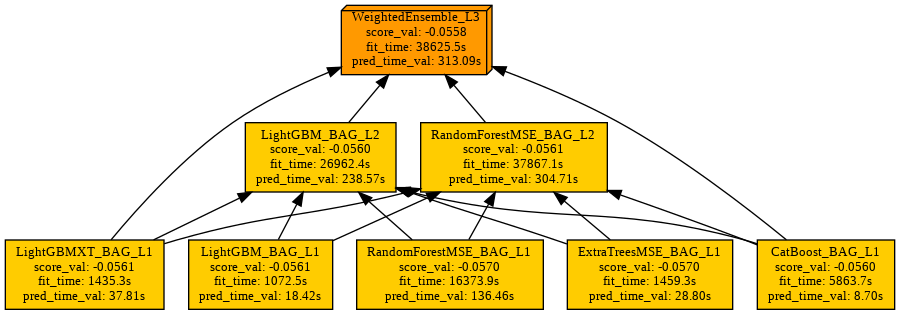

In [25]:
predictor.plot_ensemble_model(filename='ensemble_model.png')
display(Image('./AG_accident_models/ensemble_model.png'))

In [26]:
# !zip -r /kaggle/working/AG_accident_models /kaggle/working/AG_accident_models.zip
!zip -r {FOLDER}{NAME_EXT}.zip /kaggle/working/{FOLDER}{NAME_EXT}

  adding: kaggle/working/AG_accident_predictions_FE468-CPU/ (stored 0%)
  adding: kaggle/working/AG_accident_predictions_FE468-CPU/oof_ag_FE468-CPU.parquet (deflated 10%)
  adding: kaggle/working/AG_accident_predictions_FE468-CPU/pred_ag_FE468-CPU.parquet (deflated 9%)


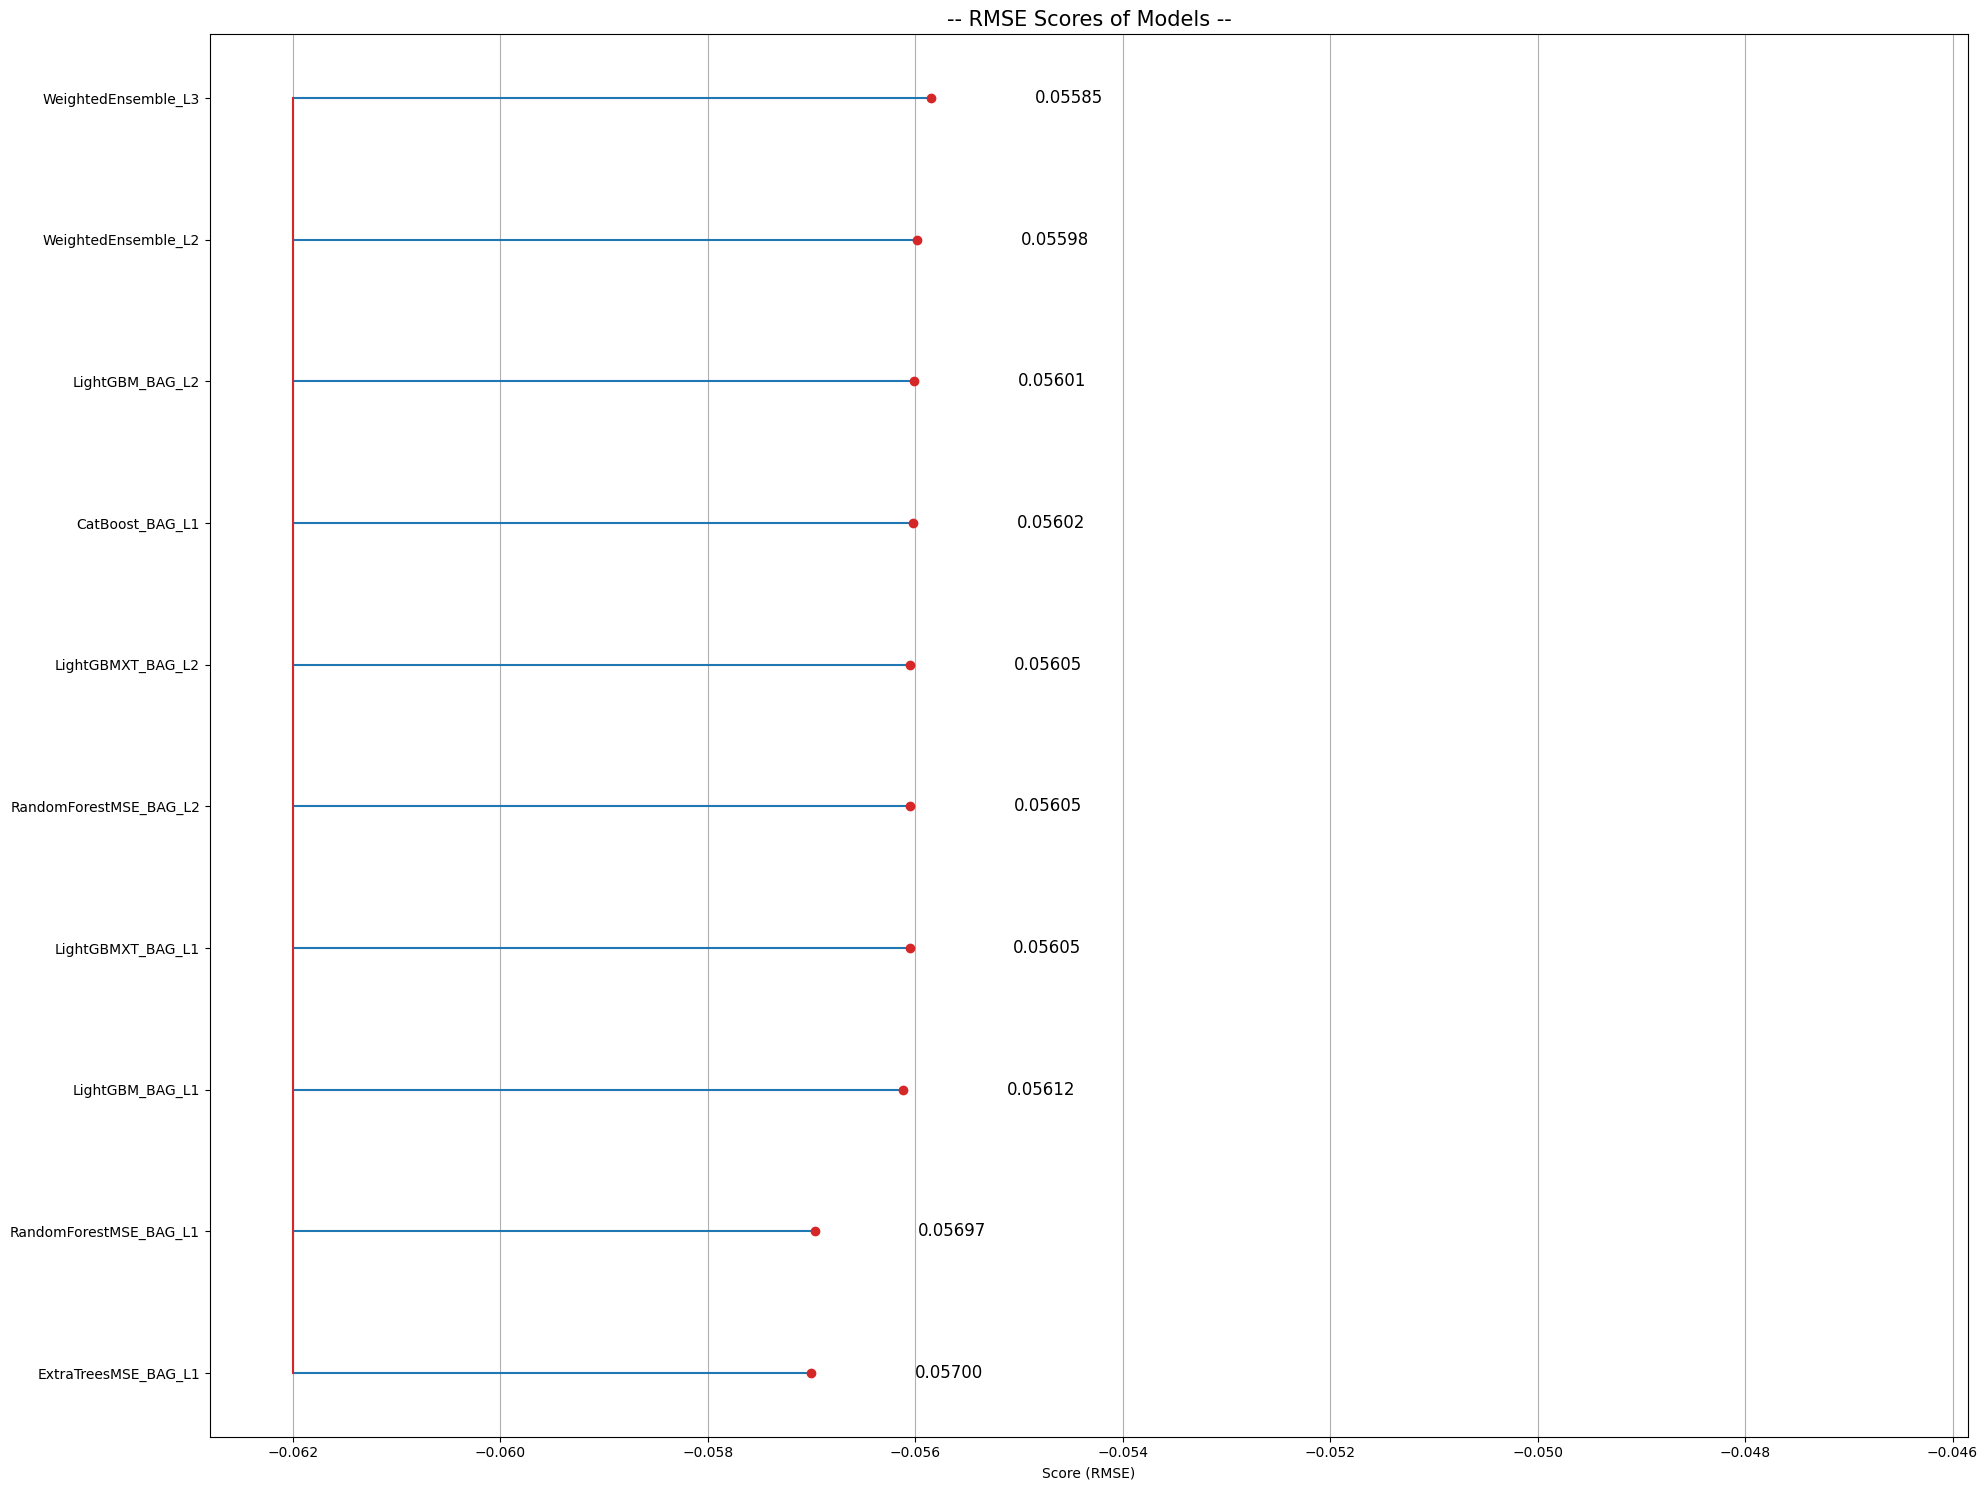

In [27]:
## -- Extract model scores --
result_ = dict(zip(leaderboard['model'], leaderboard['score_val']))
result_df = pd.DataFrame.from_dict(result_, orient='index').sort_values(0)

max_score = result_df.max().item()
min_score = result_df.min().item()

## -- PLOT MODELS & SCORES --
plt.figure(figsize=(20, 15))
plt.stem(
    result_df.index,
    result_df[0],
    orientation = 'horizontal',
    bottom = min_score - 0.005,
    markerfmt = 'C3o'
)
plt.xlim(min_score - 0.0058, max_score + 0.01)
plt.xlabel('Score (RMSE)')
plt.title('-- RMSE Scores of Models --', fontsize=15)

for i, value in enumerate(result_df[0]):
    plt.text(value+1e-3, i, f'{abs(value):.5f}', ha='left', va='center', fontdict=dict(size=12))

plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [28]:
# predictor.model_names()

In [29]:
# ## -- Permutation Feature Importances --
# feat_imp = predictor.feature_importance(
#                         data = X_test,
#                         # time_limit = 3600,
#                         # model = 'LightGBM_BAG_L1',
#                         # features = None,
#                         # feature_stage = 'transformed',
#                         # subsample_size = 5000,
#                         # num_shuffle_sets = 10,
#                         # include_confidence_band = True,
#                         confidence_level = 0.95,
#                         # silent = False
# ) 

# feat_imp.style.background_gradient(subset=["importance"], cmap="Spectral")

In [30]:
# plt.figure(figsize=(18, 35))
# sns.barplot(data=feat_imp, y=feat_imp.index, x=feat_imp.importance)
# plt.tick_params(axis='y', which='major', labelcolor='r')
# plt.title("Top Features by Permutation")
# plt.tight_layout()
# plt.show()

In [31]:
## -- OPTIONAL: Remove stored files --
!rm -r /kaggle/working/AG_accident_models
!rm -r /kaggle/working/{FOLDER}{NAME_EXT}

In [32]:
print(f"""
{'-'*48}
{'█'*5} | - AUTOGLUON NOTEBOOK COMPLETE! - | {'█'*5}
{'-'*48}
""")


------------------------------------------------
█████ | - AUTOGLUON NOTEBOOK COMPLETE! - | █████
------------------------------------------------

